# Test all
This is a place to test all the inference methods and compare them apples-to-apples.

In [43]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm

import torch
import torch_geometric as pyg
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import sbi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


In [2]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PlotRankStatistics, TARP

from tools.plot_tools import binned_plot

## Load data

In [3]:
dname = 'FS2wC100' # 'Lorenzo' # 

datapath = join('data/processed', dname)
print('Loading from:', datapath)
x = np.load(join(datapath, 'x.npy'))
theta = np.load(join(datapath, 'theta.npy'))
fold = np.load(join(datapath, 'fold.npy'))
ids = np.load(join(datapath, 'id.npy'))

Loading from: data/processed/FS2wC100


In [4]:
param_names = ['$\log_{10}M_{200c}$', '$ \log_{10}R_{200c}$']

data_names = ['x', 'y','v_{los}']

priors = np.array([[13.9, 14.8], [-0.31, 0.05]])

Rmax = 1.5

In [5]:
x_batch = [x[ids==i] for i in np.sort(np.unique(ids))]
N_batch = np.array([len(x_) for x_ in x_batch])
theta_batch = np.array([theta[ids==i][0] for i in np.sort(np.unique(ids))])
fold_batch = np.array([fold[ids==i][0] for i in np.sort(np.unique(ids))])

def get_adjacency(x, rmax=1.2):
    graph = skn.radius_neighbors_graph(x[:,:2], rmax, mode='distance', include_self=True).toarray()
    adj = np.nonzero(graph)
    return tuple(adj)

rmax=1.5
adj_batch = [get_adjacency(x_, rmax=rmax) for x_ in x_batch]

In [6]:
print('Number of unique galaxies:', len(x)) 
print('Number of unique clusters:', len(x_batch))

Number of unique galaxies: 24452
Number of unique clusters: 996


In [107]:
# focus on mass for now
theta = theta[:, 0:1]
theta_batch = theta_batch[:, 0:1]
param_names = param_names[0:1]

In [8]:
import math
from numbers import Number

import torch
from torch.distributions import constraints, Distribution
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)

class TruncatedStandardNormal(Distribution):
    """Truncated Standard Normal distribution.

    Source: https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        "a": constraints.real,
        "b": constraints.real,
    }
    has_rsample = True
    eps = 1e-6

    def __init__(self, a, b, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(
            batch_shape, validate_args=validate_args
        )
        if self.a.dtype != self.b.dtype:
            raise ValueError("Truncation bounds types are different")
        if any(
            (self.a >= self.b)
            .view(
                -1,
            )
            .tolist()
        ):
            raise ValueError("Incorrect truncation range")
        eps = self.eps
        self._dtype_min_gt_0 = eps
        self._dtype_max_lt_1 = 1 - eps
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp(eps, 1 - eps)
        self._log_Z = self._Z.log()
        little_phi_coeff_a = torch.nan_to_num(self.a, nan=math.nan)
        little_phi_coeff_b = torch.nan_to_num(self.b, nan=math.nan)
        self._lpbb_m_lpaa_d_Z = (
            self._little_phi_b * little_phi_coeff_b
            - self._little_phi_a * little_phi_coeff_a
        ) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        self._variance = (
            1
            - self._lpbb_m_lpaa_d_Z
            - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        )
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.a, self.b)

    @property
    def mean(self):
        return self._mean

    @property
    def variance(self):
        return self._variance

    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x**2) * 0.5).exp() * CONST_INV_SQRT_2PI

    def _big_phi(self, x):
        phi = 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())
        return phi.clamp(self.eps, 1 - self.eps)

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        y = self._big_phi_a + value * self._Z
        y = y.clamp(self.eps, 1 - self.eps)
        return self._inv_big_phi(y)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        out = CONST_LOG_INV_SQRT_2PI - self._log_Z - (value**2) * 0.5
        out.masked_fill_((value < self.a) | (value > self.b), -float("inf"))
        return out.squeeze()
    
    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape, device=self.a.device).uniform_(
            self._dtype_min_gt_0, self._dtype_max_lt_1
        )
        out = self.icdf(p)
        if len(out.shape) == 1:
            return out.unsqueeze(-1)
        return out  # this is a hack


class TruncatedNormal(TruncatedStandardNormal):
    """Truncated Normal distribution.

    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    has_rsample = True

    def __init__(self, loc, scale, a, b, validate_args=None):
        # scale = scale.clamp_min(self.eps)
        self.loc, self.scale, a, b = broadcast_all(loc, scale, a, b)
        self._non_std_a = a
        self._non_std_b = b
        a = (a - self.loc) / self.scale
        b = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a, b, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._variance = self._variance * self.scale**2
        self._entropy += self._log_scale

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self._non_std_a, self._non_std_b)

    def _to_std_rv(self, value):
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        sample = self._from_std_rv(super().icdf(value))

        # clamp data but keep gradients
        sample_clip = torch.stack(
            [sample.detach(), self._non_std_a.detach().expand_as(sample)], 0
        ).max(0)[0]
        sample_clip = torch.stack(
            [sample_clip, self._non_std_b.detach().expand_as(sample)], 0
        ).min(0)[0]
        sample.data.copy_(sample_clip)
        return sample

    def log_prob(self, value):
        value = self._to_std_rv(value)
        return super(TruncatedNormal, self).log_prob(value) - self._log_scale

In [10]:
from scipy.optimize import minimize
eps=1e-6
thmin, thmax = np.min(theta[:,0])*(1-eps), np.max(theta[:,0])*(1+eps)
def func(x):
    prior = TruncatedNormal(x[0], x[1], thmin, thmax, validate_args=False)
    return -np.sum(prior.log_prob(torch.Tensor(theta)).numpy())

pmu, pstd = minimize(func, x0=[13.8, 0.3], method='Nelder-Mead', tol=1e-6).x
print(f'Fitted prior mean: {pmu:.4f}, std: {pstd:.4f}')

Fitted prior mean: 13.6976, std: 0.3171


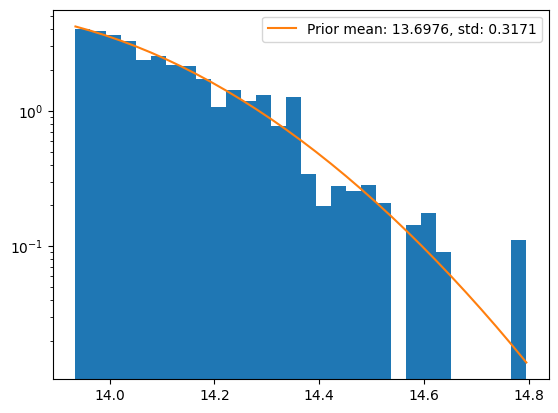

In [11]:
plt.semilogy()
h, bins, _ = plt.hist(theta, 30, density=True)

prior = TruncatedNormal(pmu, pstd, thmin, thmax, validate_args=False)
y = prior.log_prob(torch.Tensor(bins)).exp().numpy()
plt.plot(bins, y, label=f'Prior mean: {pmu:.4f}, std: {pstd:.4f}')
plt.legend()

In [142]:
# Prior scatter
pred = np.median(prior.sample(theta.shape).numpy())

print(f'Prior scatter: {np.std(pred-theta):.4f}')

Prior scatter: 0.1503


## M-$\sigma$

In [92]:
gapper = lambda x: np.sqrt(np.sum((x-np.mean(x))**2)/(len(x)-1))

logsigv_batch = np.log10([gapper(x_[:,2]) for x_ in x_batch])

In [101]:
# fit a linear regression
lr = LinearRegression().fit(theta_batch[:,0:1], logsigv_batch)

pi = lr.intercept_
alpha = lr.coef_[0]
res = logsigv_batch - lr.predict(theta_batch[:,0:1])
scatter = np.std(res) / np.abs(alpha)
ll = norm.logpdf(res, 0, np.std(res)).sum()

print(f'scatter: {scatter:.4f} dex')
print(f'log likelihood: {ll:.4f}')

scatter: 1.8029 dex
log likelihood: 297.9676


Text(0.5, 1.0, 'M-$\\sigma_v$ relation')

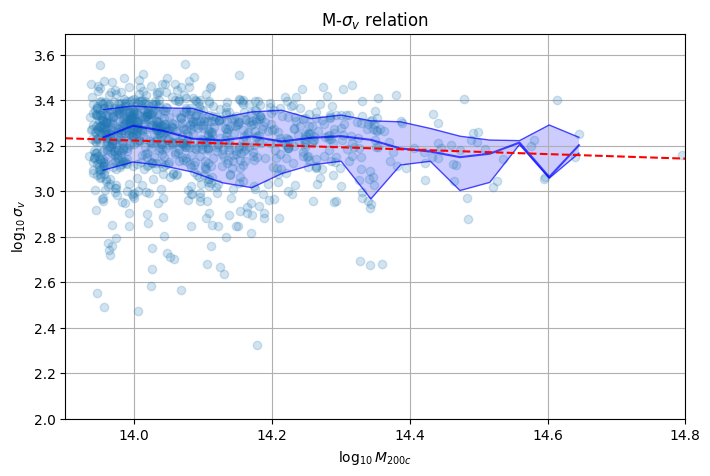

In [85]:
f, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(theta_batch[:,0], logsigv_batch, 'o', alpha=0.2)
_ = binned_plot(theta_batch[:,0], logsigv_batch, ax=ax, n=20, color='b')
ax.plot(priors[0], lr.predict(priors[0].reshape(-1,1)), 'r--')
ax.grid()
ax.set_xlim(*priors[0])
ax.set_ylim(2)
ax.set_xlabel(param_names[0])
ax.set_ylabel('$\log_{10}\sigma_v$')
ax.set_title('M-$\sigma_v$ relation')

## Galaxy-based NLE

In [62]:
ind = [0,1]
mask = np.isin(fold, ind)
train_loader = NumpyLoader(x=x[mask], theta=theta[mask])
test_loader = NumpyLoader(x=x[~mask], theta=theta[~mask])

x_test, theta_test = x[~mask], theta[~mask]

mask = np.isin(fold_batch, ind)
x_test_batch = [x_batch[i] for i in np.where(mask)[0]]
theta_test_batch = theta_batch[mask]

In [13]:
# define a prior
prior = TruncatedNormal(pmu, pstd, thmin, thmax, validate_args=False)
# prior = sbi.utils.BoxUniform(low=[thmin], high=[thmax], device='cpu')

# define an inference class (here, we are doing amortized likelihood inference)
inference_class = sbi.inference.SNLE

# instantiate your neural networks to be used as an ensemble
nets = [
    # sbi.utils.likelihood_nn(model='maf', hidden_features=50, num_transforms=5),
    # sbi.utils.likelihood_nn(model='made', hidden_features=50, num_transforms=5),
    sbi.utils.likelihood_nn(model='mdn', hidden_features=50, num_components=3),
]

# define an embedding network
embedding_net = ili.embedding.FCN(n_summary=3, n_hidden=[8])

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-5
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

In [14]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=train_loader)

INFO:root:Training model 1 out of 1 ensemble models


 Training neural network. Epochs trained: 29

INFO:root:It took 13.13797402381897 seconds to train all models.


 Neural network successfully converged after 30 epochs.

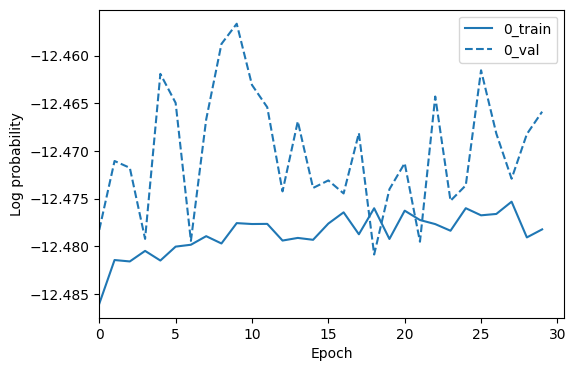

In [15]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Running vectorized MCMC with 6 chains:   0%|          | 0/3360 [00:00<?, ?it/s]

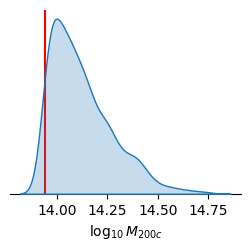

In [23]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=param_names
)
ind=0
fig = metric(
    posterior=posterior, 
    # x_obs = x_test[ind], theta_obs=theta_test[ind], 
    x=x_test, theta=theta_test,
)

100%|██████████| 123/123 [01:49<00:00,  1.13it/s]


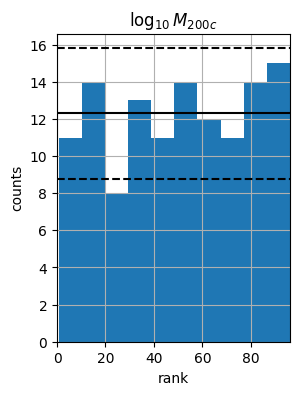

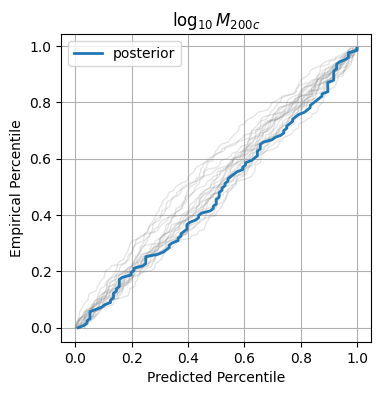

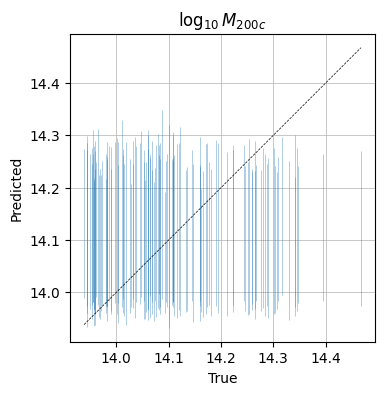

In [26]:
# calculate and plot the rank statistics to describe univariate posterior coverage
# (note, with MCMC this takes a while)
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=param_names
)
fig = metric(
    posterior=posterior,
    x=x[::200], theta=theta[::200]
)

In [70]:
Ntrue = len(x_test_batch)
samples = []
for i in tqdm.tqdm(range(Ntrue)):
    t = posterior.sample((100,), torch.Tensor(x_test_batch[i]).to(device),
                        method='slice_np_vectorized',
                        num_chains=6, warmup_steps=20, thin=3,
                        show_progress_bars=False).flatten()
    samples.append(t.cpu().numpy())

100%|██████████| 207/207 [06:55<00:00,  2.01s/it]


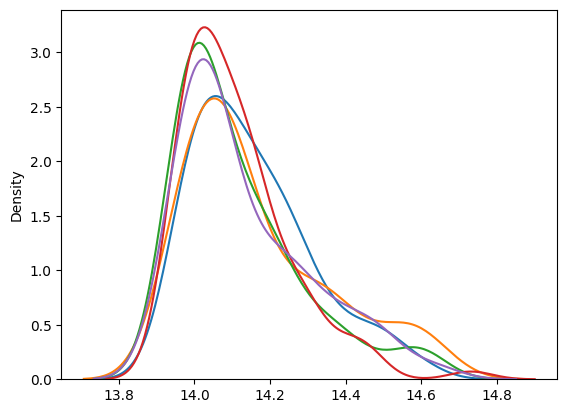

In [71]:
# plt.semilogy()
for i in range(5):
    _ = sns.kdeplot(samples[i])

(13.9, 14.8)

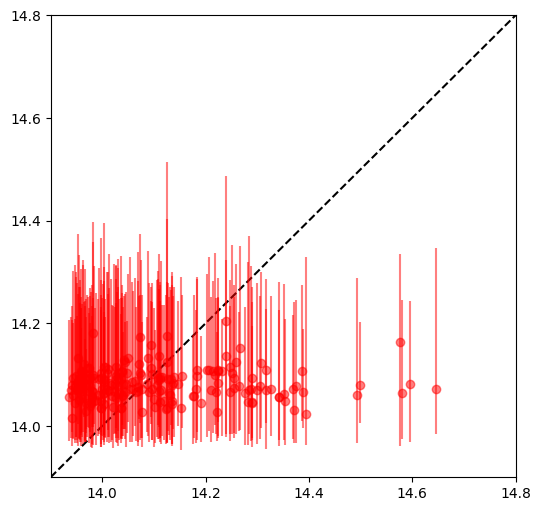

In [74]:
trues = theta_test_batch[:len(samples),0]
percs = np.percentile(samples, [16, 50, 84], axis=1)

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(priors[0], priors[0], 'k--')
ax.errorbar(trues, percs[1], yerr=[percs[1]-percs[0], percs[2]-percs[1]],
            fmt='ro', label='68%', alpha=0.5)
ax.set_xlim(*priors[0])
ax.set_ylim(*priors[0])

In [75]:
print(f'Galaxy-based NLE scatter: {np.std(percs[1]-trues):.4f}')

Galaxy-based NLE scatter: 0.1469


## Summary FCN

In [108]:
def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0)]
    return np.concatenate(feats)

x_summ = np.array([calc_sum(x_) for x_ in x_batch])
x_summ

ind = [0,1]
mask = np.isin(fold_batch, ind)
train_loader = NumpyLoader(x=x_summ[mask], theta=theta_batch[mask])
test_loader = NumpyLoader(x=x_summ[~mask], theta=theta_batch[~mask])

x_test, theta_test = x_summ[~mask], theta_batch[~mask]

In [131]:
# define a prior
prior = TruncatedNormal(pmu, pstd, thmin, thmax, validate_args=False)
# prior = sbi.utils.BoxUniform(low=[thmin], high=[thmax], device='cpu')

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='nsf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='mdn', hidden_features=50, num_components=2),
]

# define an embedding network
embedding_net = ili.embedding.FCN(n_summary=x_summ.shape[-1], n_hidden=[16,16,16])

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-5
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

In [132]:
posterior, summaries = runner(loader=train_loader)

INFO:root:Training model 1 out of 4 ensemble models


 Neural network successfully converged after 335 epochs.

INFO:root:Training model 2 out of 4 ensemble models


 Training neural network. Epochs trained: 421

INFO:root:Training model 3 out of 4 ensemble models


 Training neural network. Epochs trained: 126422 epochs.

INFO:root:Training model 4 out of 4 ensemble models


 Training neural network. Epochs trained: 365130 epochs.

INFO:root:It took 32.240599155426025 seconds to train all models.


 Neural network successfully converged after 374 epochs.

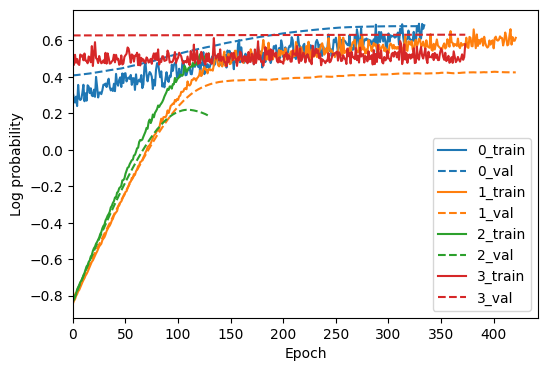

In [133]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 213 posterior samples:   0%|          | 0/213 [00:00<?, ?it/s]

Drawing 113 posterior samples:   0%|          | 0/113 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

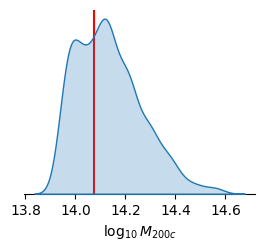

In [134]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='nuts',
    sample_params={'num_chains': 6, 'burn_in':100, 'thin': 3},
    labels=param_names
)
ind=0
fig = metric(
    posterior=posterior,
    x_obs=x_test[ind], theta_obs=theta_test[ind],
    x=x_test, theta=theta_test,
)

100%|██████████| 996/996 [00:11<00:00, 87.42it/s]


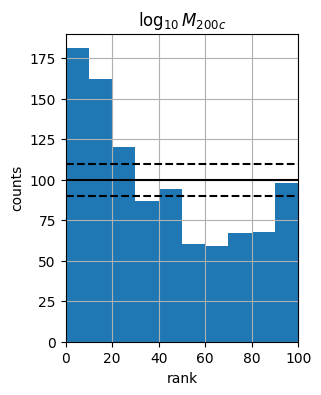

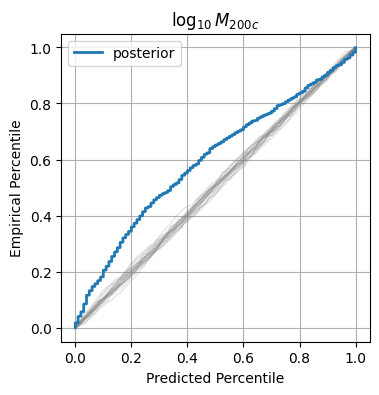

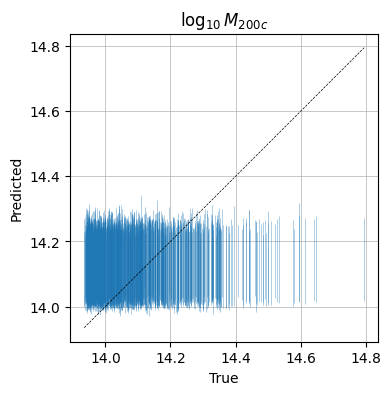

In [135]:
# calculate and plot the rank statistics to describe univariate posterior coverage
# (note, with MCMC this takes a while)
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='direct',
    labels=param_names
)
fig = metric(
    posterior=posterior,
    x=x_summ, theta=theta_batch
)

In [137]:
Ntrue = len(x_test)
samples = []
for i in tqdm.tqdm(range(Ntrue)):
    t = posterior.sample((100,), torch.Tensor(x_test[i]).to(device),
                        show_progress_bars=False).flatten()
    samples.append(t.cpu().numpy())

100%|██████████| 789/789 [00:09<00:00, 86.92it/s]


(13.9, 14.8)

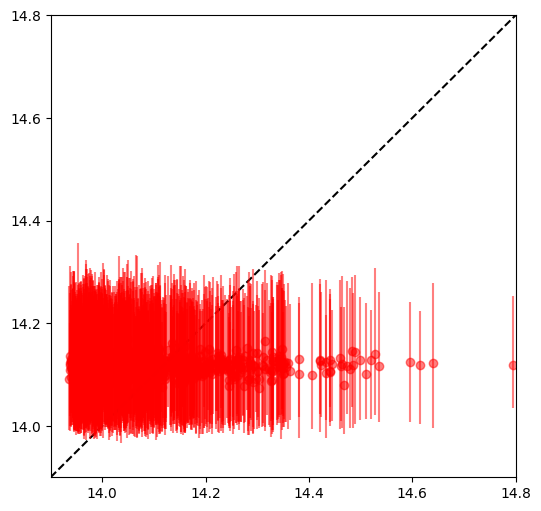

In [139]:
trues = theta_test[:len(samples),0]
percs = np.percentile(samples, [16, 50, 84], axis=1)

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(priors[0], priors[0], 'k--')
ax.errorbar(trues, percs[1], yerr=[percs[1]-percs[0], percs[2]-percs[1]],
            fmt='ro', label='68%', alpha=0.5)
ax.set_xlim(*priors[0])
ax.set_ylim(*priors[0])

In [140]:
print(f'Summary-based NLE scatter: {np.std(percs[1]-trues):.4f}')

Galaxy-based NLE scatter: 0.1350


## Graph NPE